This notebook estimates the parameters for the three state model usign the Approximate Bayesian Calculation implemented in PyMC

In [1]:
import os
from numba import njit
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
from scipy.integrate import odeint
from matplotlib.widgets import Button, Slider
from EvolutionExperiment import EvolutionExperimentTwoStates
print(f"Running on PyMC v{pm.__version__}")
plt.rcParams['text.usetex'] = True

Running on PyMC v5.10.4


In [2]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
# SET THE WORKING DIRECTORY
CWD = '/Users/miguel/Documents/Internship_CENTURI'
os.chdir(CWD)
## DEFINES WORKING CONSTANTS
#FILENAME = args.filename
FILENAME = 'plate_counts.csv'
SAVE_FN = FILENAME.strip().split('.')[0]


In [4]:
# Read experimental data for inference
df = pd.read_csv('/Users/miguel/Documents/Internship_CENTURI/data/plate_counts.csv')
df = df.sort_values(['founder', 'replicate']).reset_index(drop=True)
temp_df = df[(df.founder=='delserCGA') & (df.replicate == 1)]

x = temp_df.day.values
y = temp_df[['frac_small']].values

test_p0 = np.array([1, 0])
num_days = 101
# When using delserCGA the replication rate of the founder is found using the growth curve fits
# Additionally, the replication rate of the mutant is assumed to be the rate of M2lop obtained with the gc fit
# The number of days in the experiment is 100, for testing let's assume 10
# M2lop replication rate : 0.05447838370459147
# delserCGA replication rate : 0.04060341705556068
# Mutations per generation for wild type (https://doi.org/10.1093/gbe/evu284)
# 4.25e-9
# Using the same value for all as a proxy

test_params = {'r_f' : 0.04060, 'r_c' : 0.05448, 'mu_fc' : 4.25e-9, 'mu_cf' : 4.25e-3, 'K' : 1e2}
model_experiment = EvolutionExperimentTwoStates('delserCGA', num_days , test_params, dilution_percentage= 1e-2)
model_experiment.days_experiment = x
model_experiment.p0 = test_p0
#model_experiment.p1 = test_p0

# Approximate Bayesian Calculation (ABC)
With the defined model above we will run ABC

In [28]:
with pm.Model() as model:
    alpha = pm.Uniform("new_alpha", lower = 1, upper = 2)
    mu_fc = pm.HalfNormal("new_mu_fd", sigma = 1e-5)
    mu_cf = pm.HalfNormal("new_mu_df", sigma = 1e-4)

    sim = pm.Simulator("sim", model_experiment.run_experiment_for_abc, params = (alpha, mu_fc, mu_cf), epsilon = 0.0001, observed = y.ravel(), distance = "laplace")

    abc_data = pm.sample_smc(chains = 4)

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


In [6]:
abc_data

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

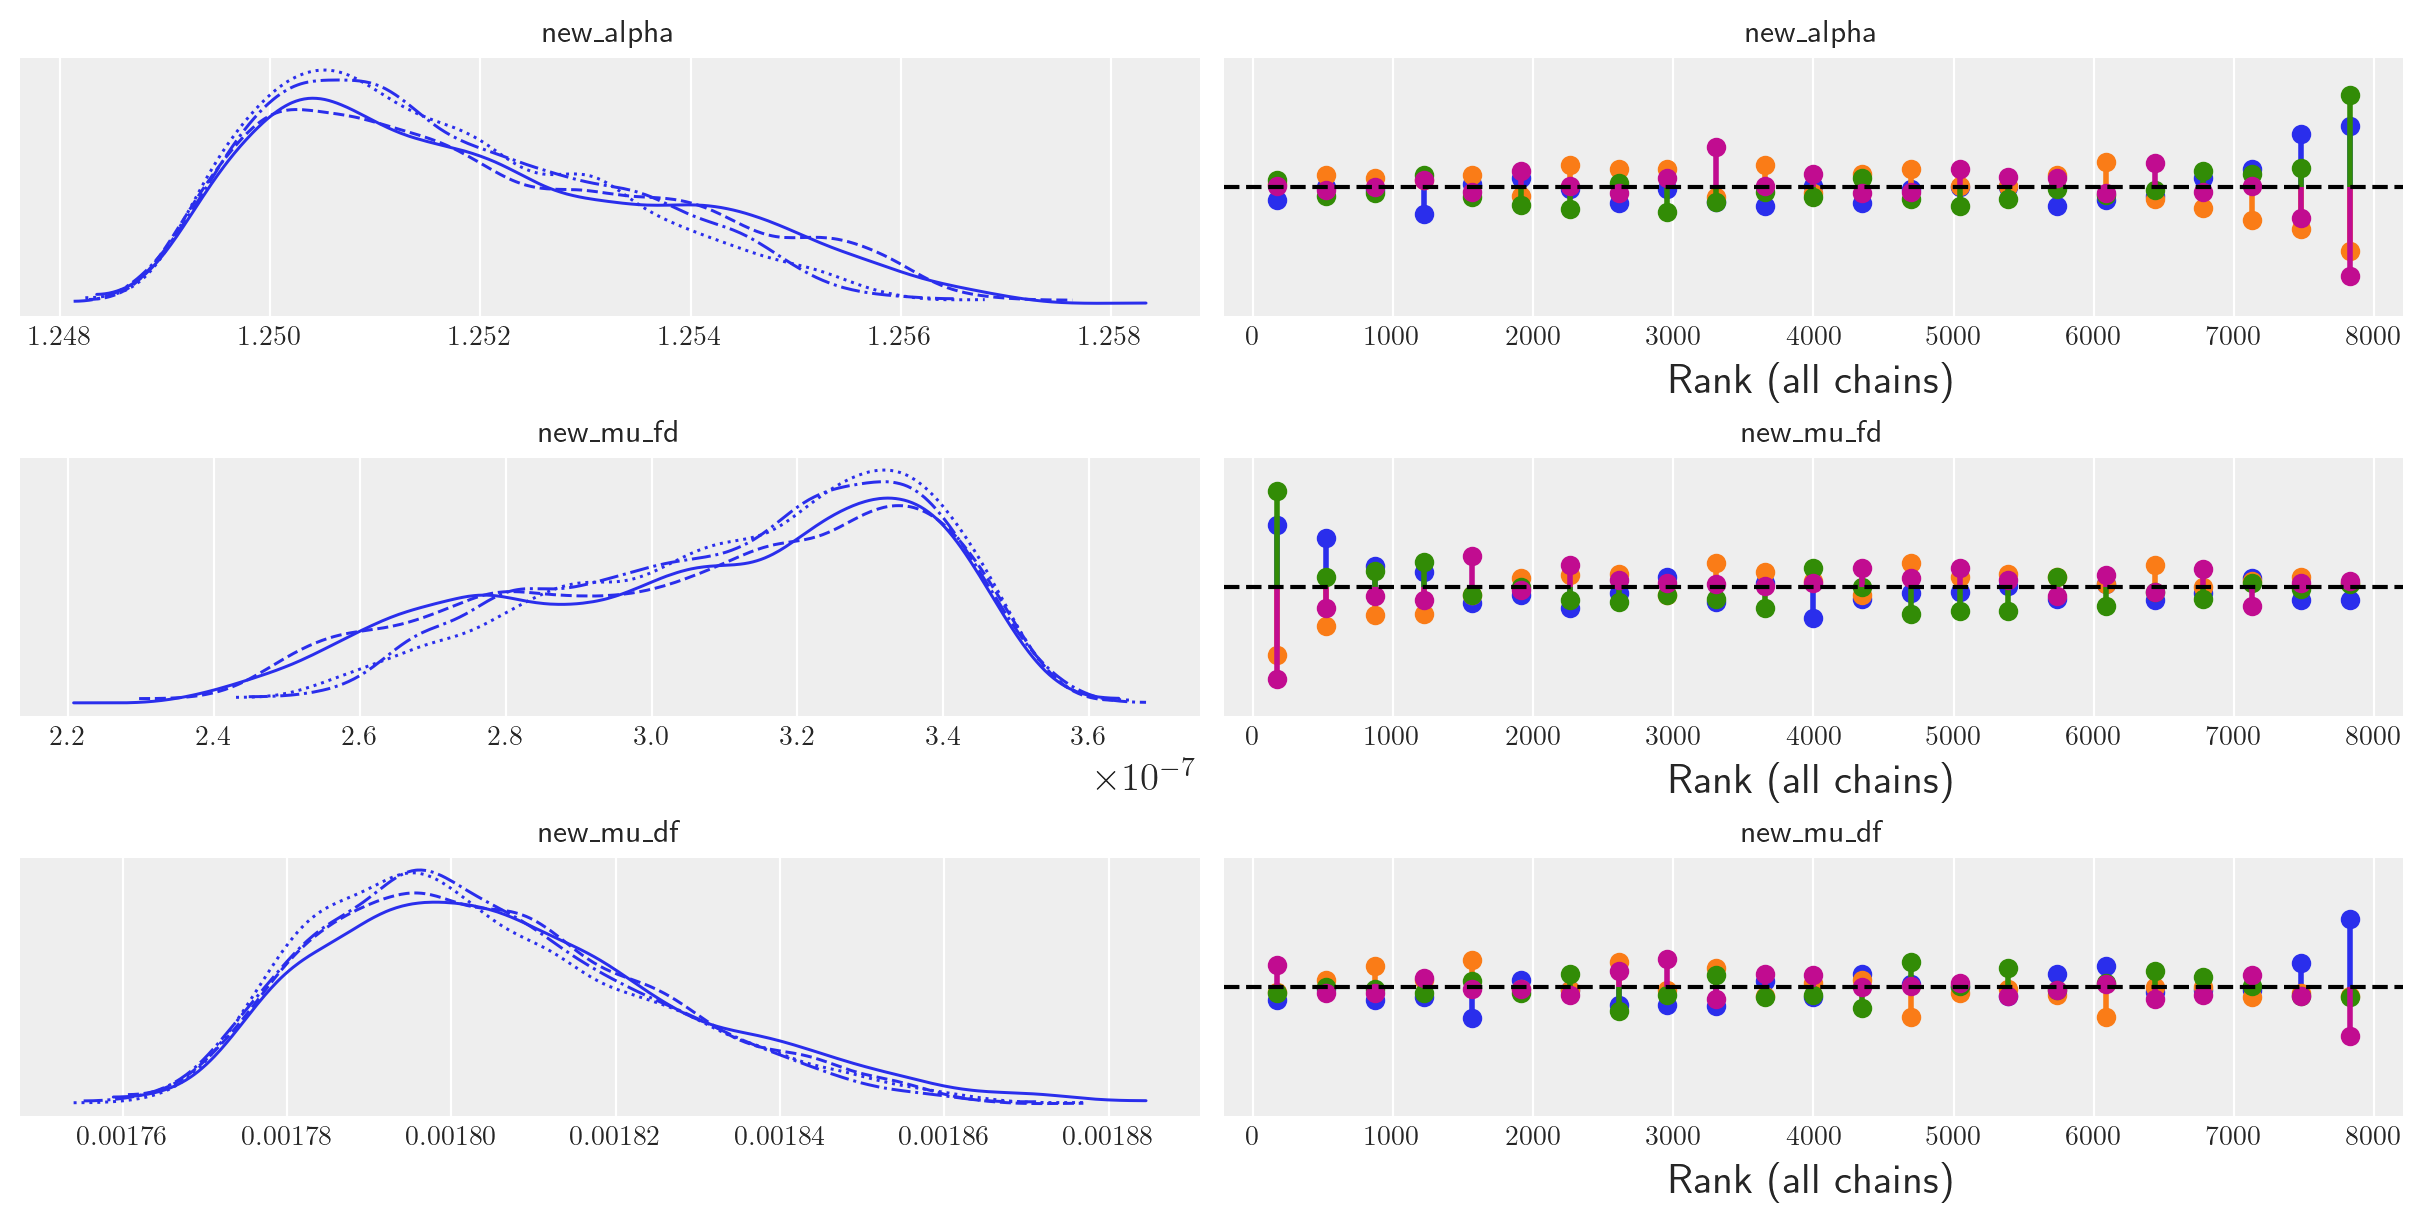

In [29]:
az.plot_trace(abc_data, kind="rank_vlines");

In [32]:
az.summary(abc_data, kind="stats", round_to = "none")

,mean,sd,hdi_3%,hdi_97%
new_alpha,1.251788e+00,1.774106e-03,1.249052e+00,1.255113e+00
new_mu_fd,3.102185e-07,2.664657e-08,2.614367e-07,3.510369e-07
new_mu_df,1.804744e-03,2.048507e-05,1.770540e-03,1.843486e-03


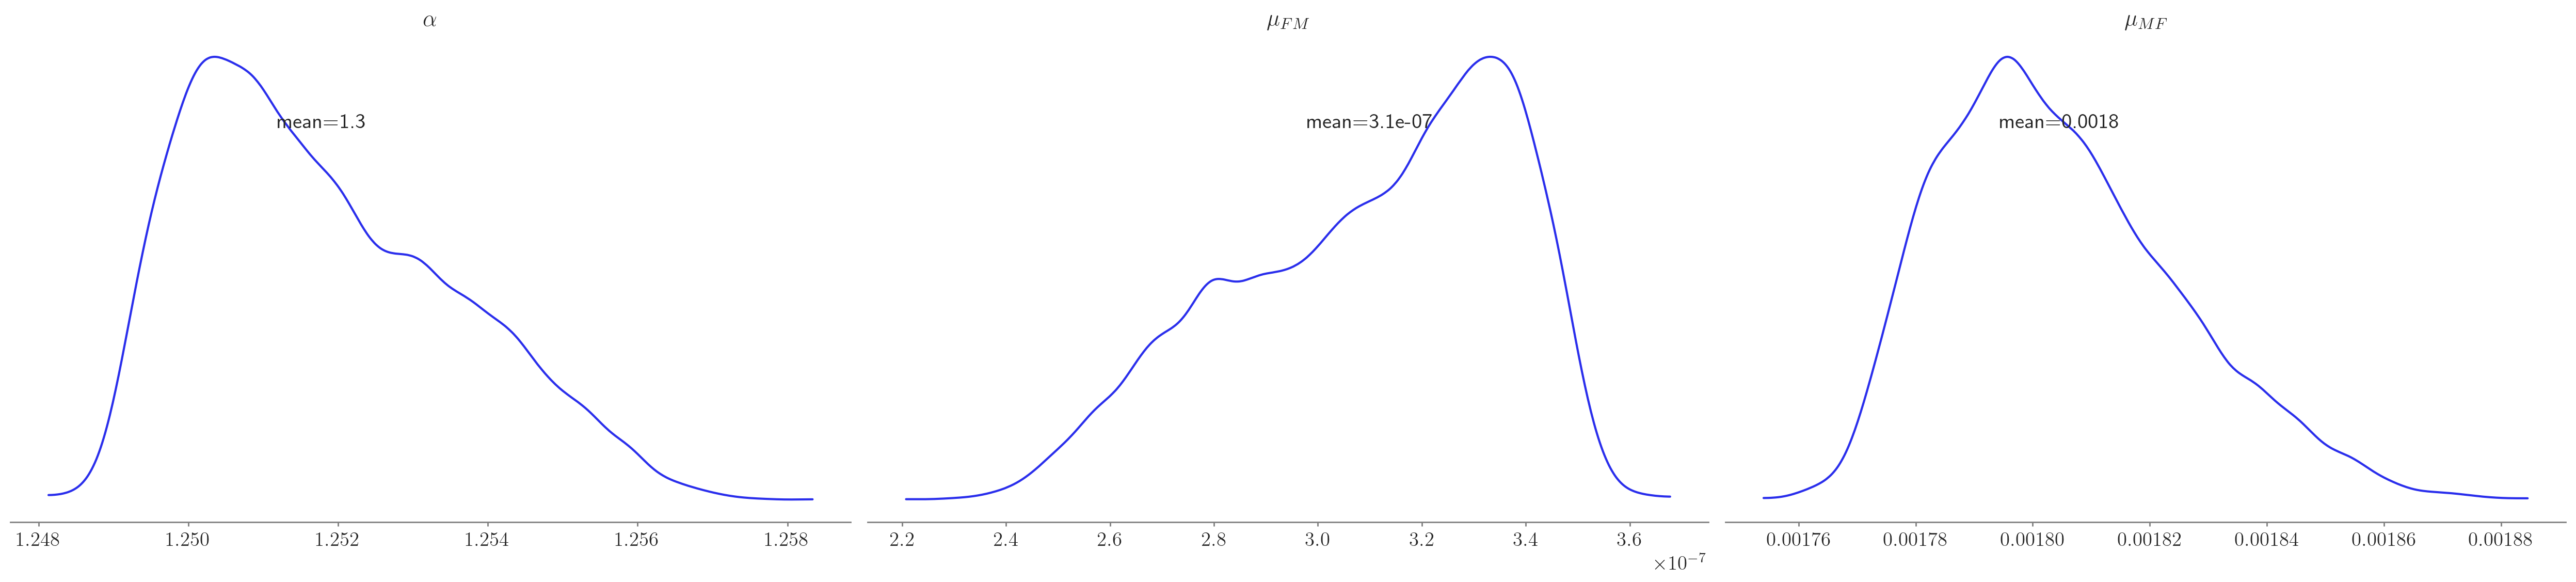

In [38]:
import arviz.labels as azl
az.style.use("arviz-white")

labeller = azl.MapLabeller(var_name_map={"new_alpha": r"$\alpha$", 'new_mu_fd': r"$\mu_{FM}$", 'new_mu_df': r"$\mu_{MF}$"})
az.plot_posterior(abc_data, var_names = ['new_alpha', 'new_mu_fd', 'new_mu_df'], point_estimate = 'mean', labeller = labeller, hdi_prob = 'hide');
fig = plt.gcf();
fig.savefig(CWD + '/plots/abc_2st_posterior.png', dpi = 300);

In [33]:
# Read experimental data for inference
df = pd.read_csv('/Users/miguel/Documents/Internship_CENTURI/data/plate_counts.csv')
df = df.sort_values(['founder', 'replicate']).reset_index(drop=True)
temp_df = df[(df.founder=='delserCGA') & (df.replicate == 1)]

x = temp_df.day.values
y = temp_df[['frac_small']].values
x = temp_df.day.values
y = temp_df[['frac_small']].values

test_p0 = np.array([1, 0])
num_days = 101
# When using delserCGA the replication rate of the founder is found using the growth curve fits
# Additionally, the replication rate of the mutant is assumed to be the rate of M2lop obtained with the gc fit
# The number of days in the experiment is 100, for testing let's assume 10
# M2lop replication rate : 0.05447838370459147
# delserCGA replication rate : 0.04060341705556068
# Mutations per generation for wild type (https://doi.org/10.1093/gbe/evu284)
# 4.25e-9
# Using the same value for all as a proxy

#updated_params = {'r_f' : 0.04060, 'r_c' : 0.05448, 'mu_fc' : 4.25e-9, 'mu_cf' : 4.25e-3, 'K' : 1e2}
updated_params = {'r_f' : 0.04060, 'r_c' : 0.05448, 'mu_fc' : 0.0039e-06, 'mu_cf' : 1.26610510e-03, 'K' : 100}
updated_model = EvolutionExperimentTwoStates('delserCGA', num_days , updated_params, dilution_percentage= 1e-2)
updated_model.days_experiment = x
updated_model.p0 = test_p0
updated_model.alpha = 1.251788
updated_model.mu_fc = 3.102185e-07
updated_model.mu_cf = 1.804744e-03
#model_experiment.p1 = test_p0

In [34]:
updated_model.run_experiment()

Running the evolution experiment


Plot the evolution experiment results with the mean of the parameter distribution

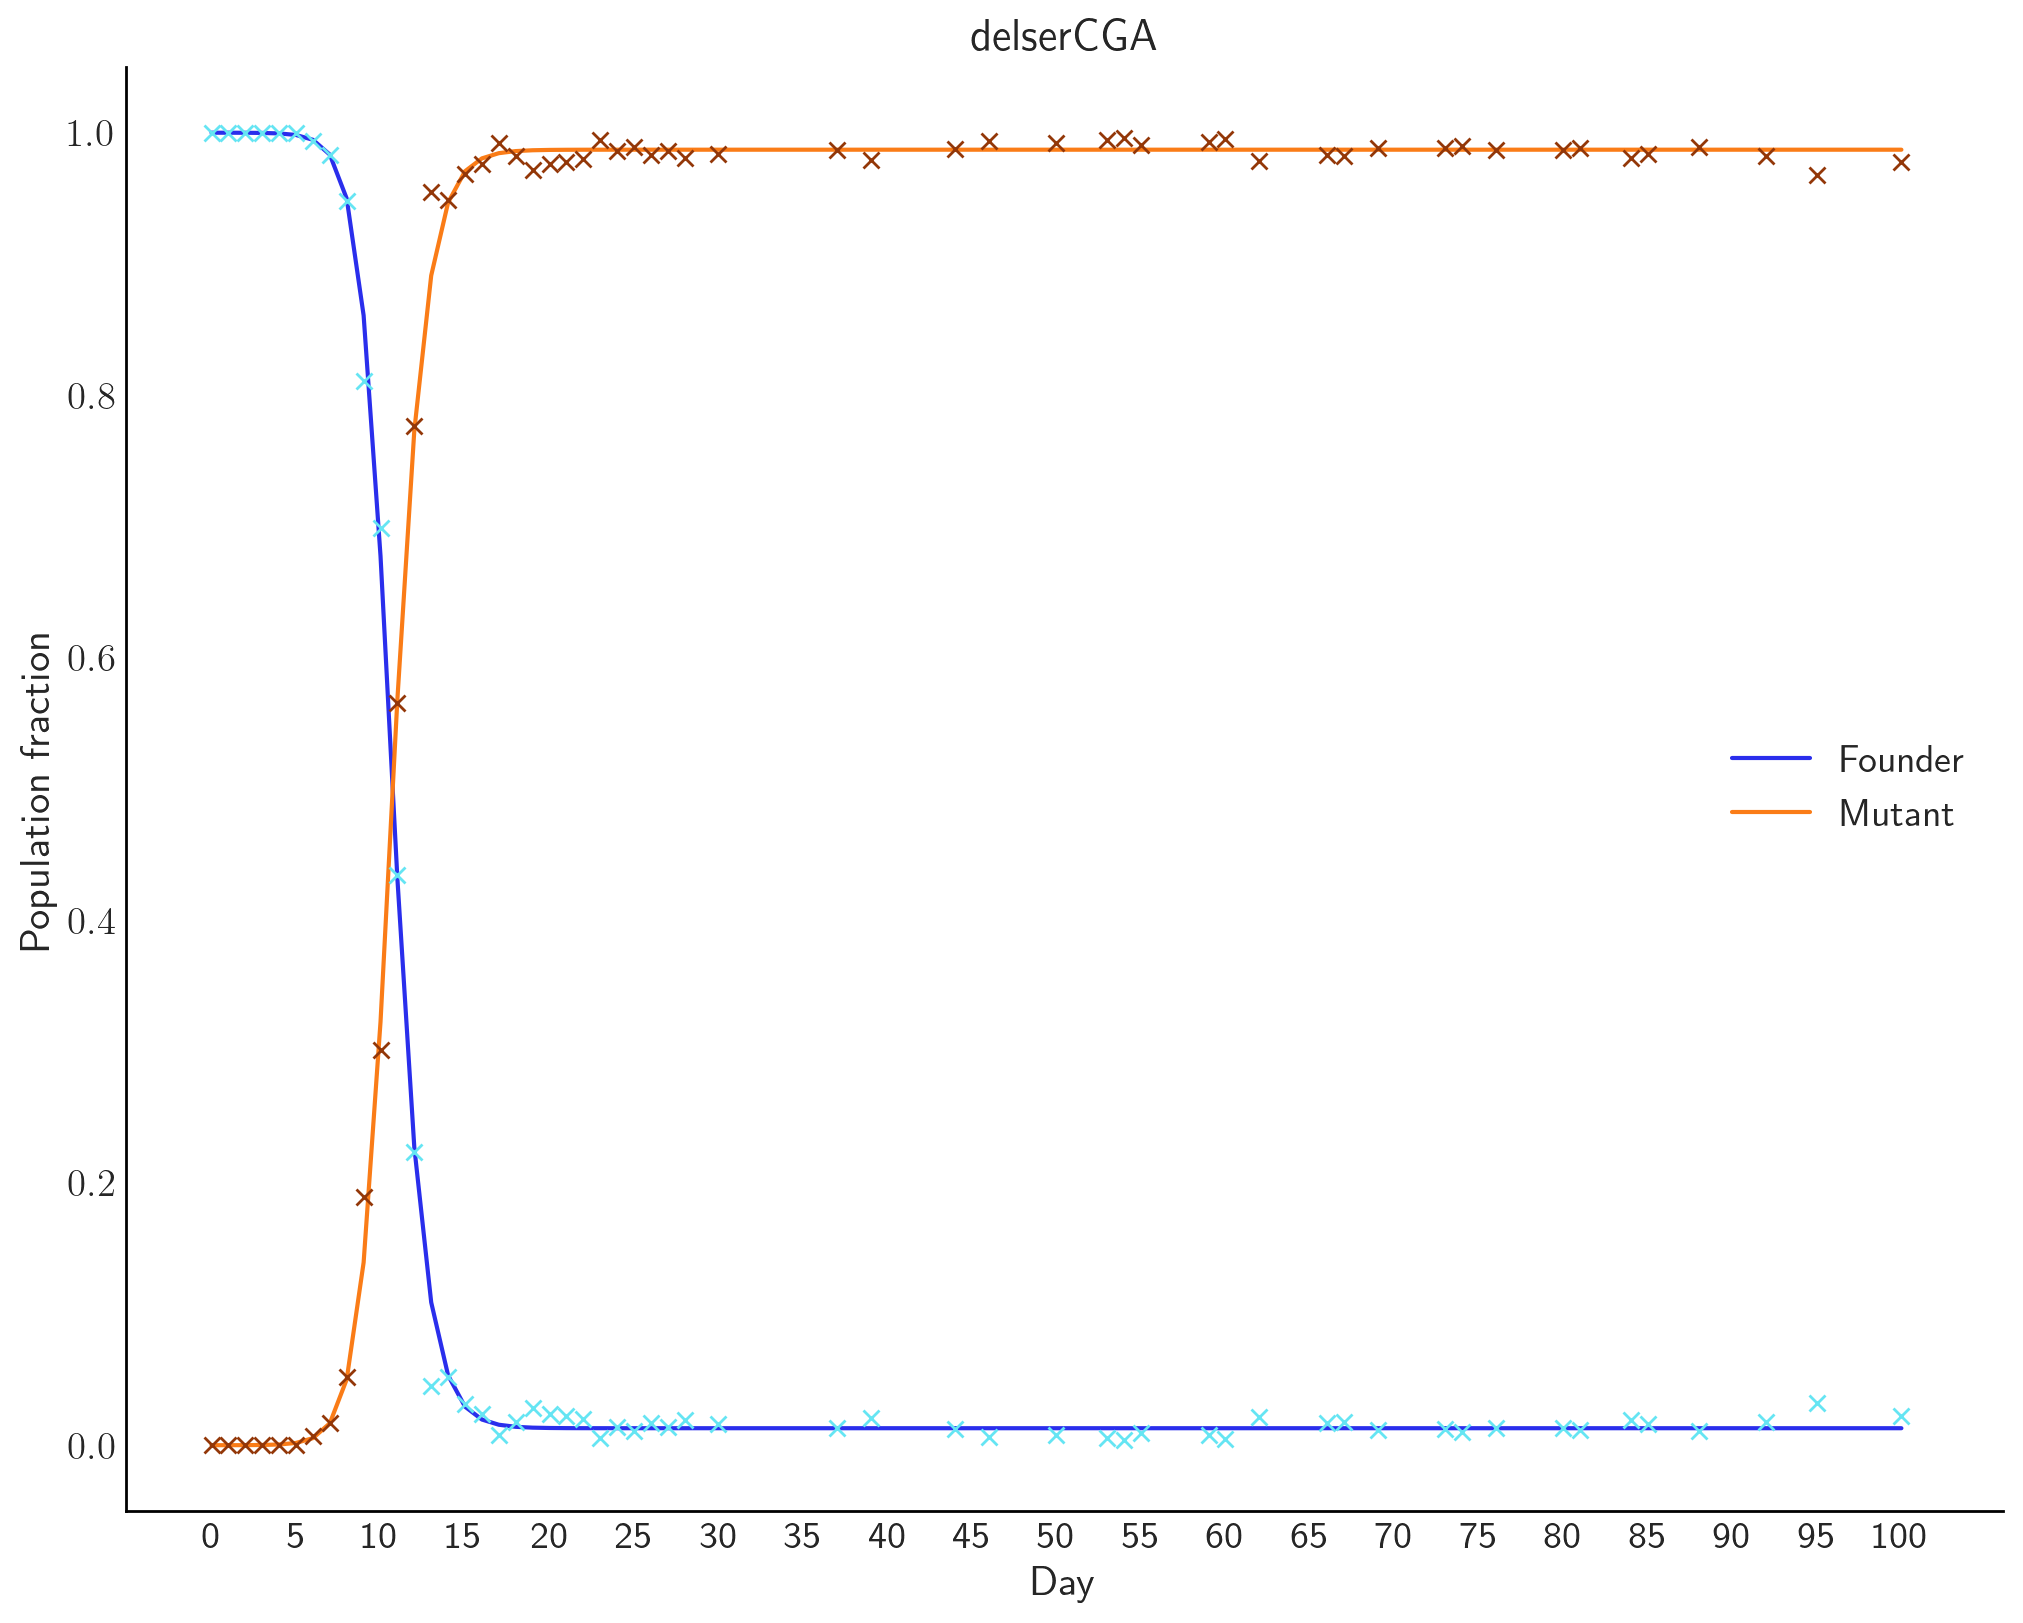

In [51]:
ax = updated_model.plot_evolution_frac()
for i, line in enumerate(ax.lines):
    if i ==2 or i ==3:
        line.remove()
ax.plot(temp_df.day.values * updated_model.time_interval.shape[0] , temp_df.frac_large, 'x', label = f'Replicate 1 large')
ax.plot(temp_df.day.values * updated_model.time_interval.shape[0], temp_df.frac_small, 'x', label = f'Replicate 1 small')
plt.show()

In [50]:
for i, line in enumerate(ax.lines):
    if i ==2 or i ==3:
        line.remove()

In [48]:
ax.lines

<Axes.ArtistList of 4 lines>

In [45]:
ax.get_lines()[2:4]

In [280]:
with pm.Model() as kl_model:
    alpha = pm.Uniform("new_alpha", lower = 1, upper = 2)
    beta = pm.Uniform("new_beta", lower = 1, upper = 2)
    mu_fd = pm.HalfNormal("new_mu_fd", sigma = 1e-5)
    mu_fs = pm.HalfNormal("new_mu_fs", sigma = 1e-5)
    mu_df = pm.HalfNormal("new_mu_df", sigma = 1e-5)
    r_s = pm.HalfNormal("new_r_s", sigma = 1e-4)

    kl_sim = pm.Simulator("kl_sim", model_experiment.run_experiment_for_inference, params = (alpha, beta, mu_fd, mu_fs, mu_df,  r_s), epsilon = 0.01, observed = y.ravel(), distance = "laplace")

    kl_abc_data = pm.sample_smc(kernel="ABC")

/var/folders/j5/gzgbj85d7fl1z1qxpqp965kc0000gq/T/ipykernel_38229/519359717.py:11: FutureWarning: The kernel string argument "ABC" in sample_smc has been deprecated. It is no longer needed to distinguish between `abc` and `metropolis`
  kl_abc_data = pm.sample_smc(kernel="ABC")
Initializing SMC sampler...
Sampling 4 chains in 4 jobs


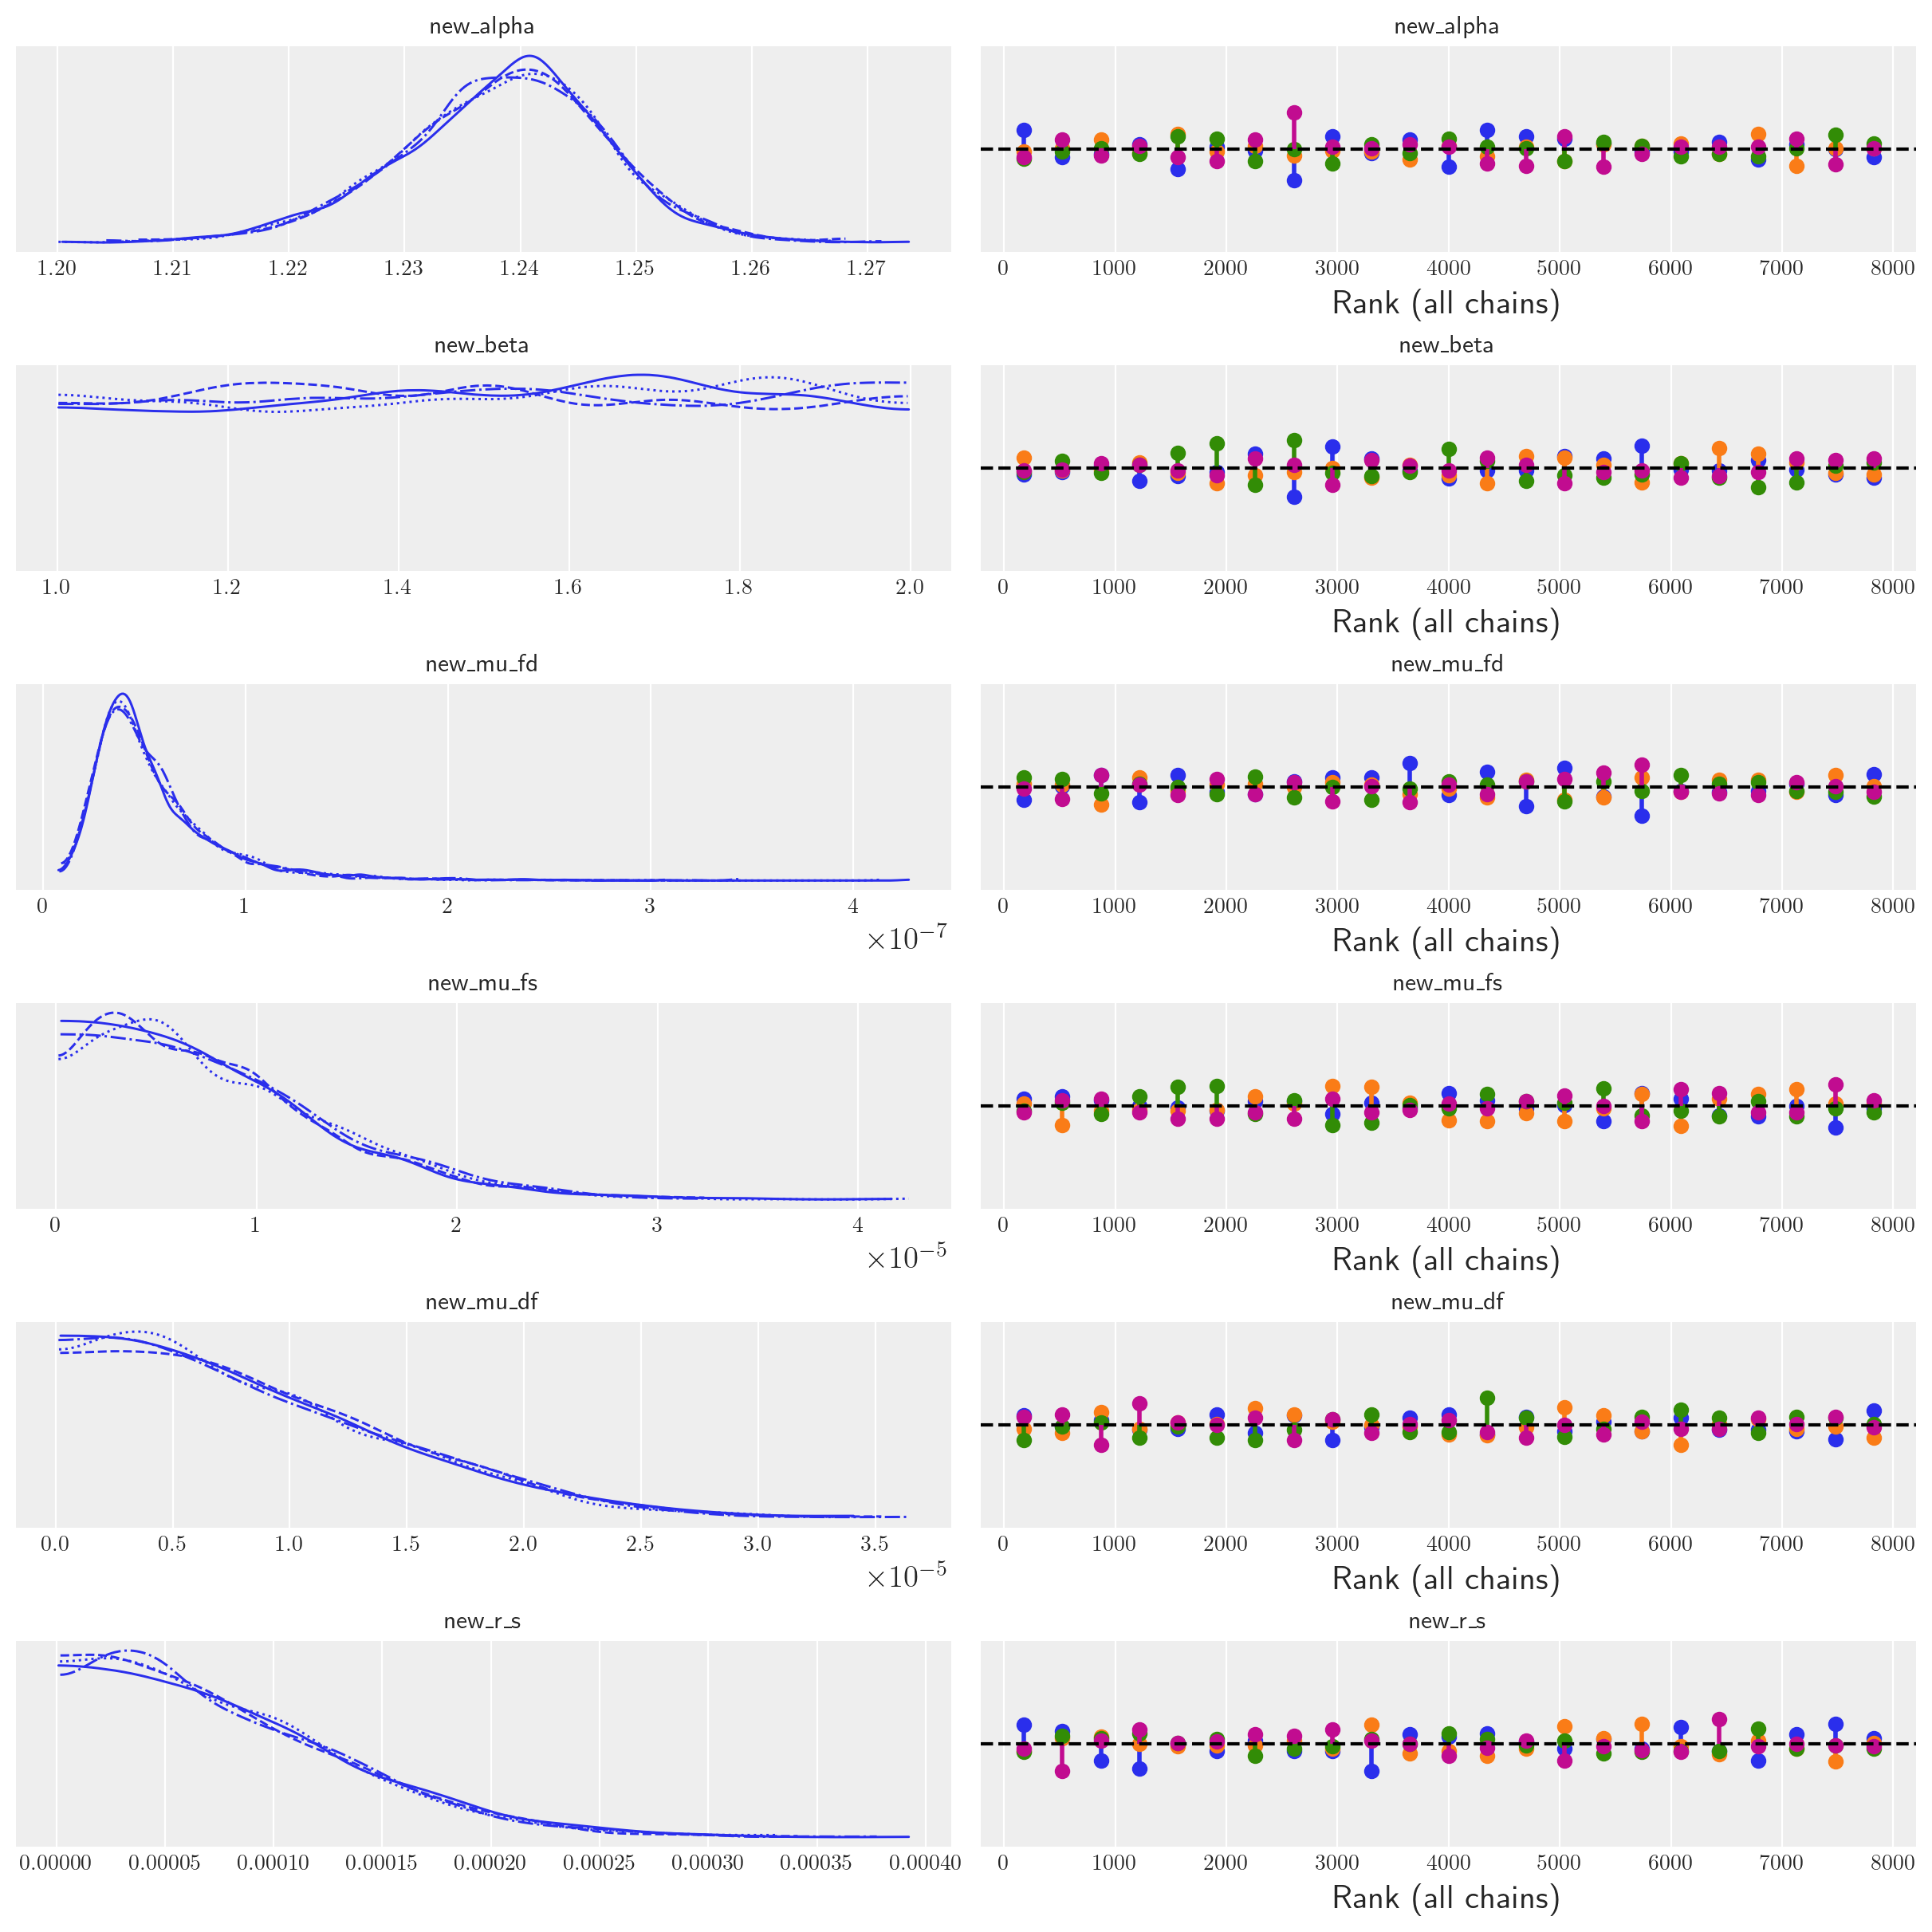

In [282]:
az.plot_trace(kl_abc_data, kind="rank_vlines");

In [31]:
az.summary(abc_data, kind="stats", round_to = "none")

,mean,sd,hdi_3%,hdi_97%
new_alpha,1.251788e+00,1.774106e-03,1.249052e+00,1.255113e+00
new_mu_fd,3.102185e-07,2.664657e-08,2.614367e-07,3.510369e-07
new_mu_df,1.804744e-03,2.048507e-05,1.770540e-03,1.843486e-03


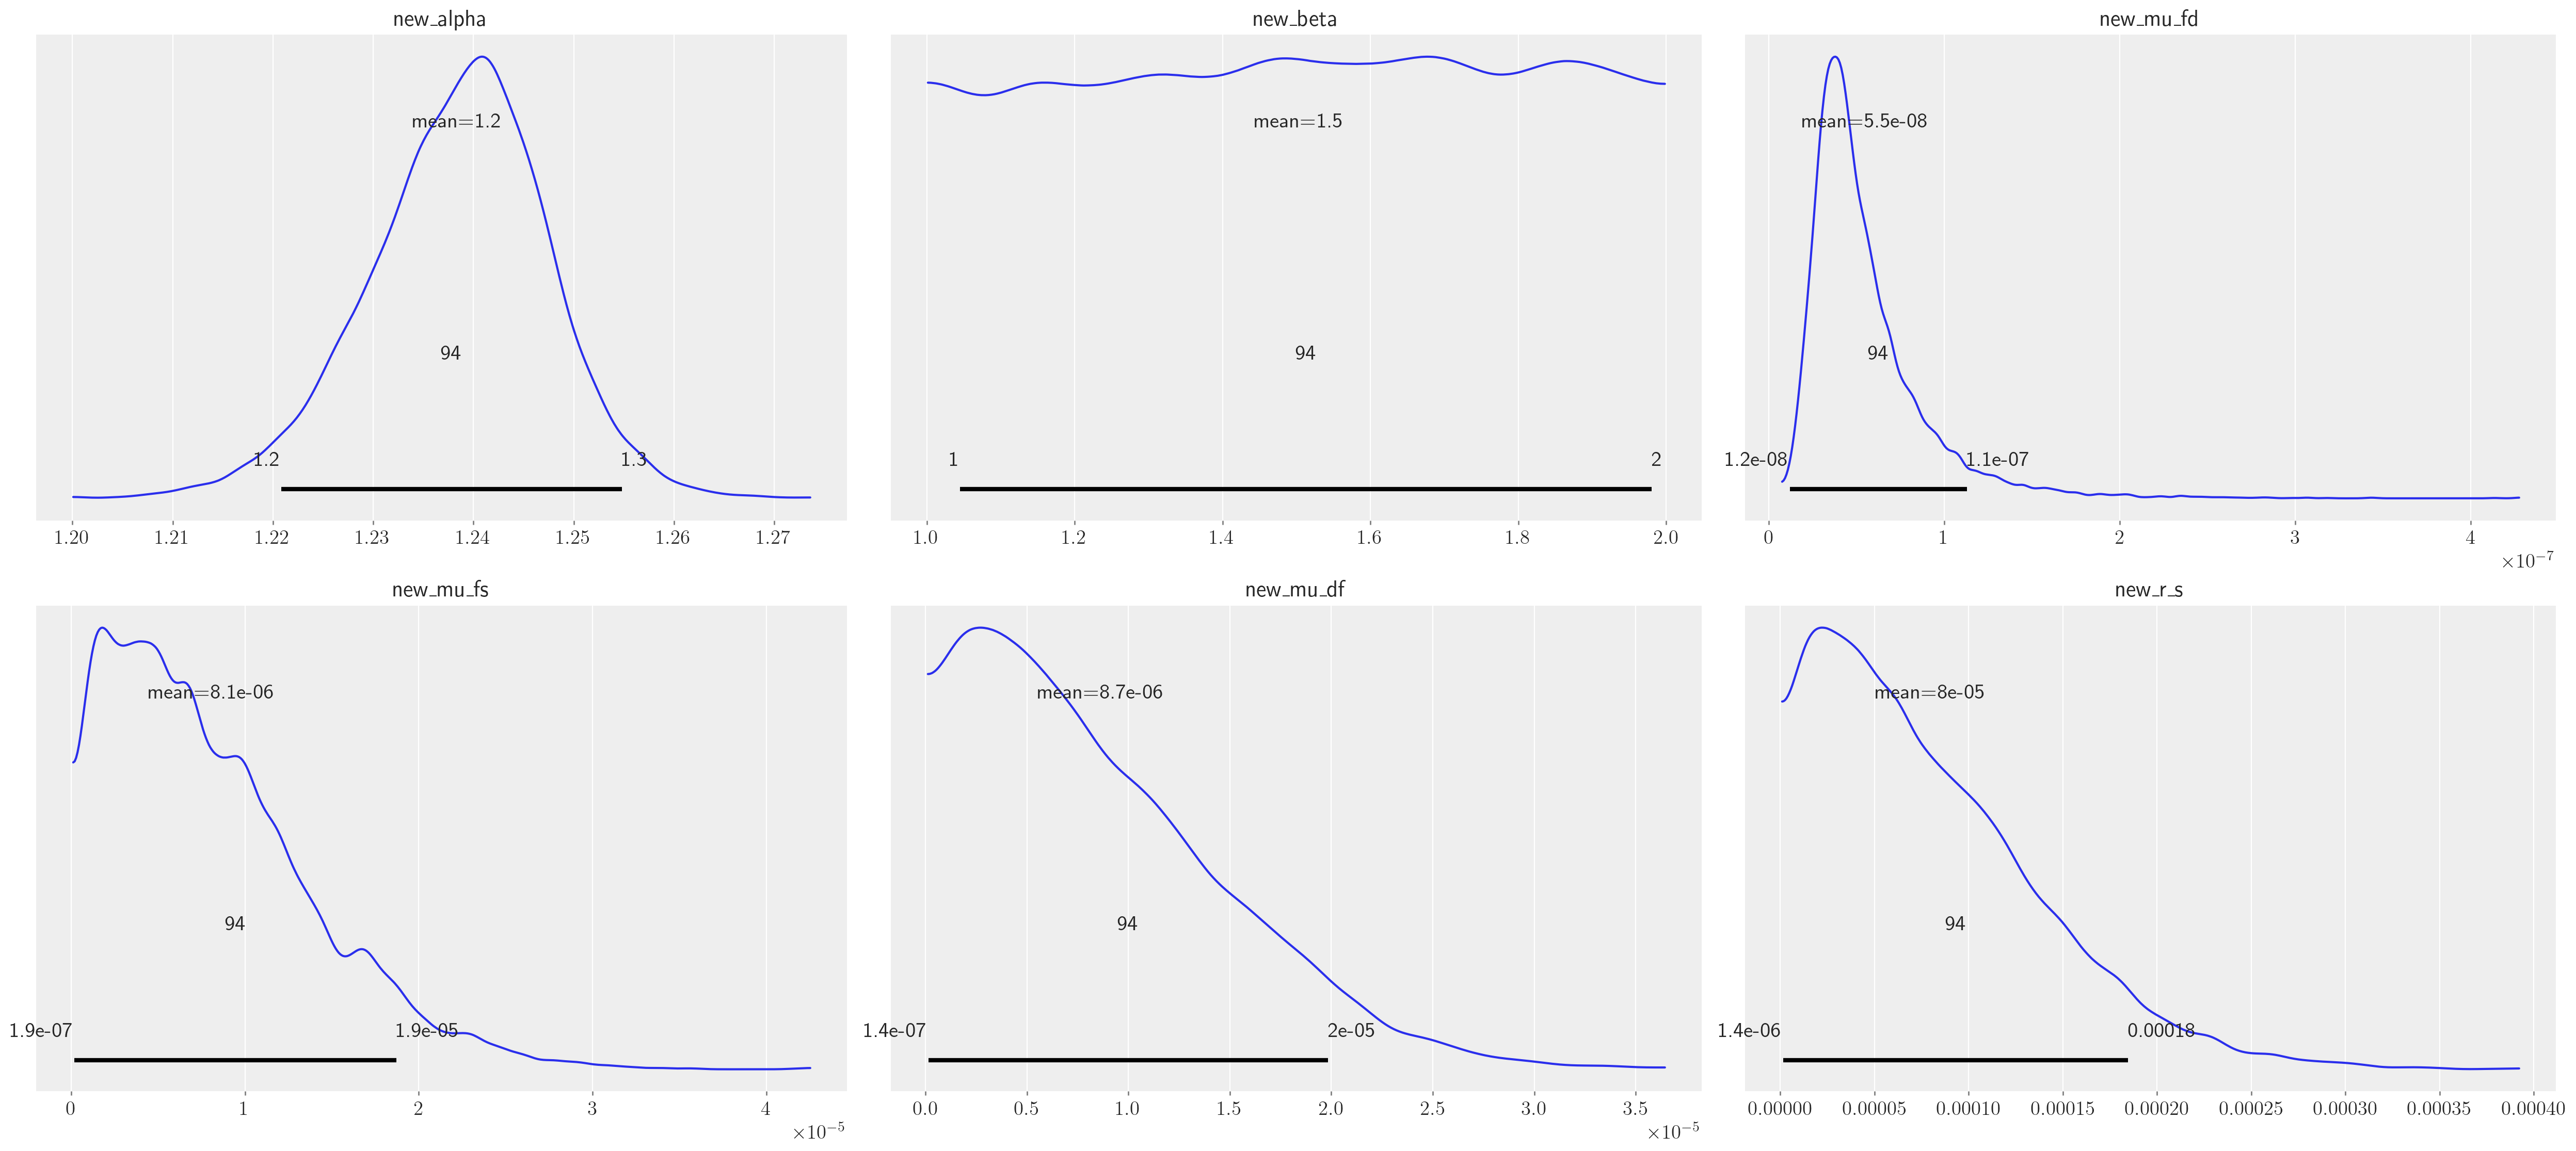

In [283]:
az.plot_posterior(kl_abc_data);

# Using the corrected initial conditions

In [284]:
# Read experimental data for inference
df = pd.read_csv('/Users/miguel/Documents/Internship_CENTURI/data/plate_counts.csv')
df = df.sort_values(['founder', 'replicate']).reset_index(drop=True)
temp_df = df[(df.founder=='delserCGA') & (df.replicate == 1)]

x = temp_df.day.values
y = temp_df[['frac_small']].values
x = temp_df.day.values
y = temp_df[['frac_small']].values

test_p0 = np.array([1, 0, 0])
num_days = 101
# When using delserCGA the replication rate of the founder is found using the growth curve fits
# Additionally, the replication rate of the mutant is assumed to be the rate of M2lop obtained with the gc fit
# The number of days in the experiment is 100, for testing let's assume 10
# M2lop replication rate : 0.05447838370459147
# delserCGA replication rate : 0.04060341705556068
# Mutations per generation for wild type (https://doi.org/10.1093/gbe/evu284)
# 4.25e-9
# Using the same value for all as a proxy

updated_params_2 = {'r_f' : 0.04060, 'r_d' : 0.05448, 'r_s' : 0.035, 'mu_fd' : 4.7e-6, 'mu_fs' : 8.1e-5, 'mu_df' : 8.1e-5, 'mu_sf' : 0.00081, 'K' : 1e2}
updated_model_2 = EvolutionExperiment('delserCGA', num_days , updated_params, dilution_percentage= 1e-2)
updated_model_2.days_experiment = x
updated_model_2.p0 = test_p0
updated_model_2.alpha = 1.251788
updated_model_2.beta = 1.5
#model_experiment.p1 = test_p0

In [285]:
with pm.Model() as kl_model:
    alpha = pm.Uniform("new_alpha", lower = 1, upper = 2)
    beta = pm.Uniform("new_beta", lower = 1, upper = 2)
    mu_fd = pm.HalfNormal("new_mu_fd", sigma = 1e-5)
    mu_fs = pm.HalfNormal("new_mu_fs", sigma = 1e-5)
    mu_df = pm.HalfNormal("new_mu_df", sigma = 1e-5)
    r_s = pm.HalfNormal("new_r_s", sigma = 1e-4)

    updated_sim_2 = pm.Simulator("updated_sim_2", updated_model_2.run_experiment_for_inference, params = (alpha, beta, mu_fd, mu_fs, mu_df, r_s), epsilon = 0.001, observed = y.ravel(), distance = "laplace")

    updated_sim_2_abc_data = pm.sample_smc(chains = 8)

Initializing SMC sampler...
Sampling 8 chains in 4 jobs


 |████████████████████████████████████████| 100.00% [100/100 00:00<?  Stage: 11 Beta: 1.000]   

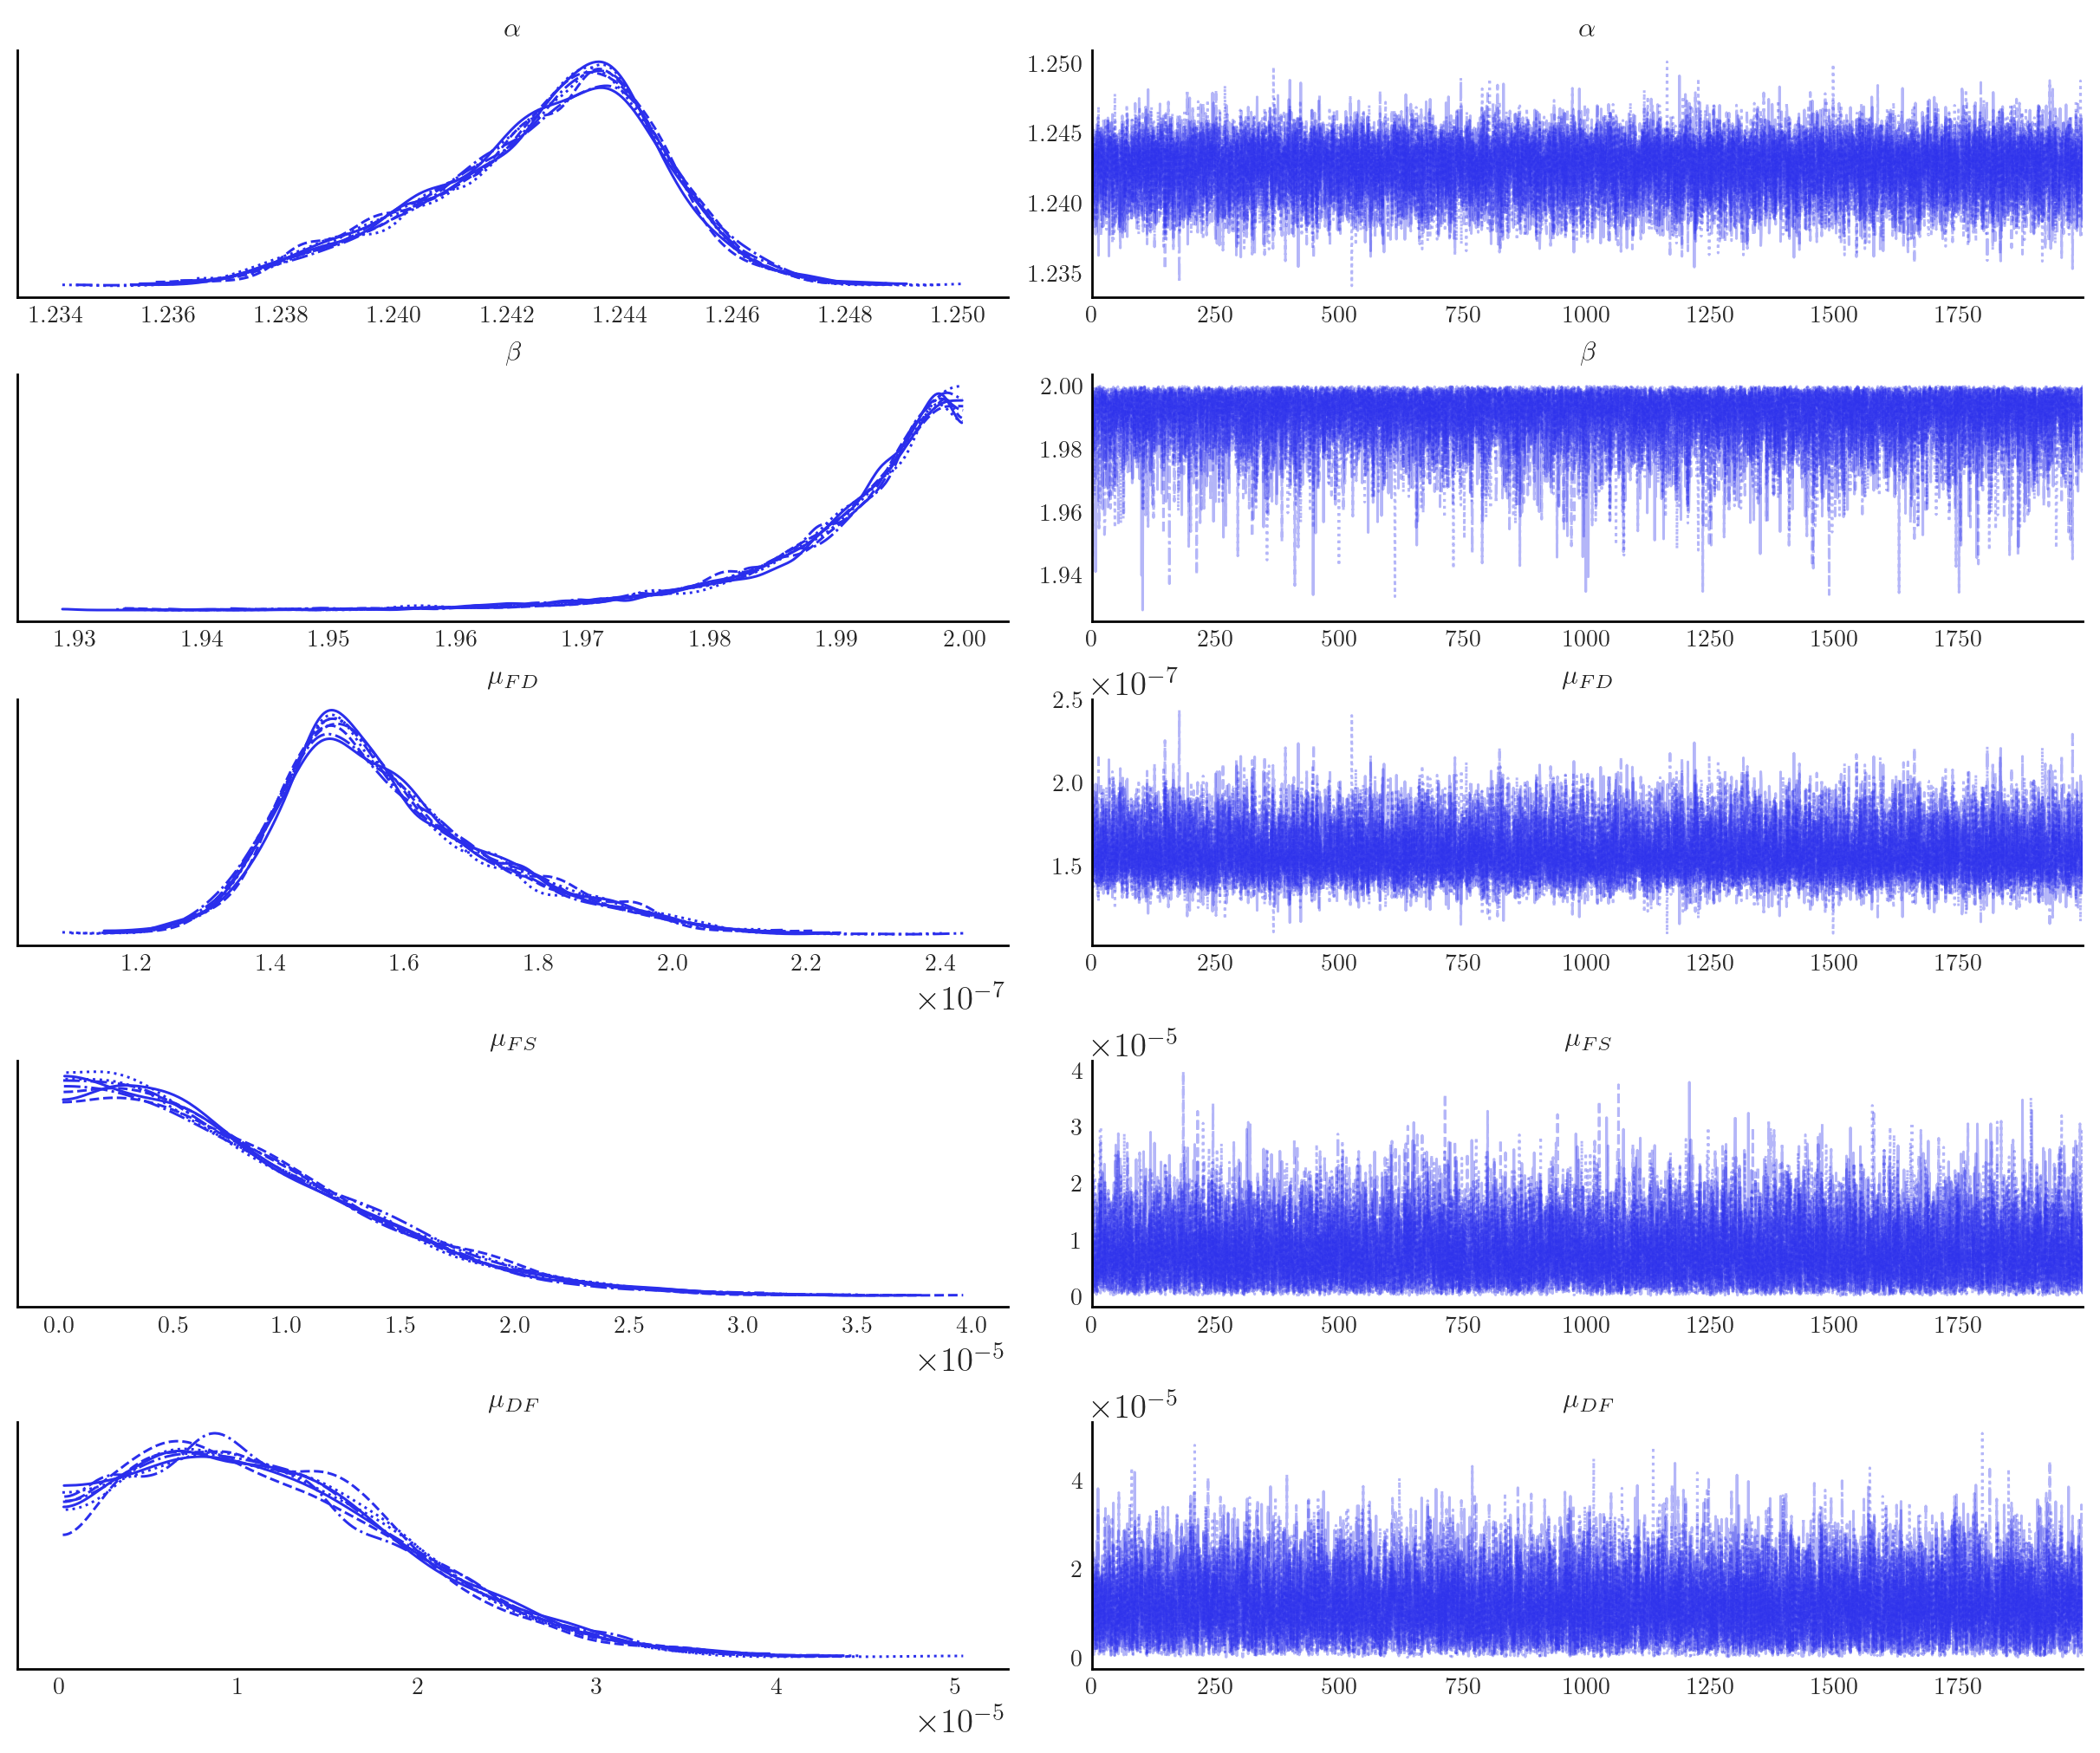

In [328]:
labeller = azl.MapLabeller(var_name_map={"new_alpha": r"$\alpha$", 'new_beta': r"$\beta$", 'new_mu_fd': r"$\mu_{FD}$", 'new_mu_fs': r"$\mu_{FS}$", 'new_mu_df': r"$\mu_{DF}$", 'new_r_s': r"$r_S$"})
az.plot_trace(updated_sim_2_abc_data, labeller = labeller, var_names = ['new_alpha', 'new_beta', 'new_mu_fd', 'new_mu_fs', 'new_mu_df', '~new_r_s']);
fig = plt.gcf();
fig.savefig(CWD + '/plots/abc_3st_param_dist.png', dpi = 300);

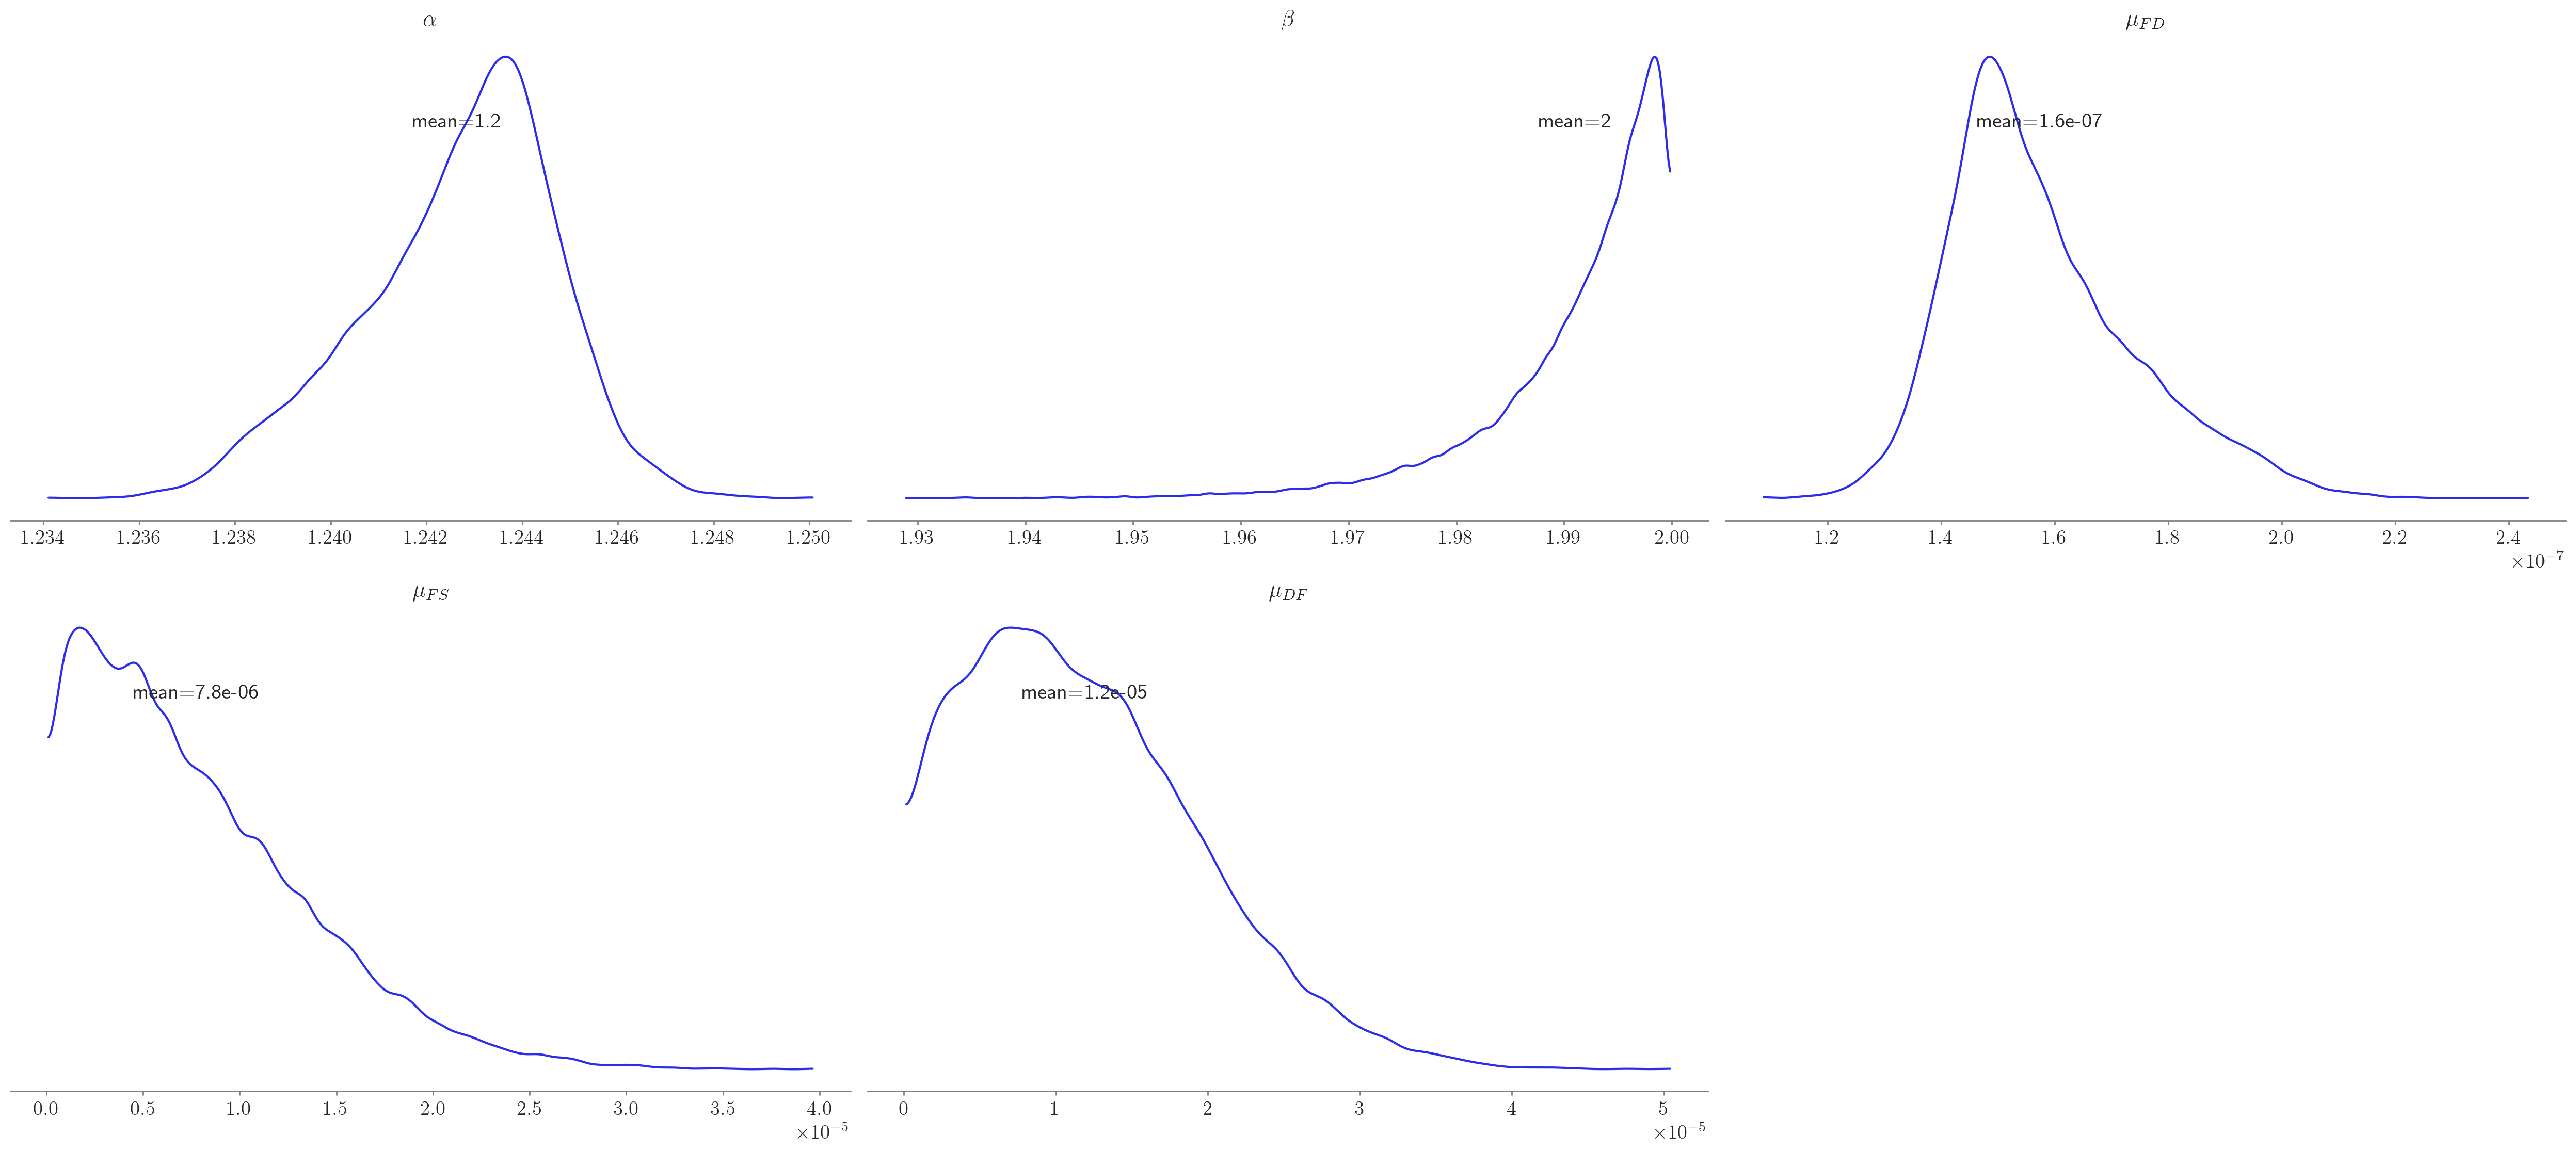

In [335]:
import arviz.labels as azl
labeller = azl.MapLabeller(var_name_map={"new_alpha": r"$\alpha$", 'new_beta': r"$\beta$", 'new_mu_fd': r"$\mu_{FD}$", 'new_mu_fs': r"$\mu_{FS}$", 'new_mu_df': r"$\mu_{DF}$", 'new_r_s': r"$r_S$"})
az.plot_posterior(updated_sim_2_abc_data, var_names = ['new_alpha', 'new_beta', 'new_mu_fd', 'new_mu_fs', 'new_mu_df', '~new_r_s'], point_estimate = 'mean', labeller = labeller, hdi_prob = 'hide');
fig = plt.gcf();
fig.savefig(CWD + '/plots/abc_3st_posterior.png', dpi = 300);

In [345]:
az.summary(updated_sim_2_abc_data, kind="stats", round_to = "none")

,mean,sd,hdi_3%,hdi_97%
new_alpha,1.242660e+00,2.047662e-03,1.238349e+00,1.245992e+00
new_beta,1.991100e+00,8.490153e-03,1.975458e+00,1.999879e+00
new_mu_fd,1.575858e-07,1.634038e-08,1.319742e-07,1.924920e-07
new_mu_fs,7.810981e-06,5.804835e-06,1.721464e-07,1.831876e-05
new_mu_df,1.199410e-05,7.597790e-06,3.071870e-07,2.523055e-05
new_r_s,8.039323e-05,5.960879e-05,8.995901e-07,1.864877e-04


In [337]:
with pm.Model() as kl_model:
    updated_sim_2_abc_data.extend(pm.sample_posterior_predictive(updated_sim_2_abc_data))

In [339]:
az.plot_ppc(updated_sim_2_abc_data, num_pp_samples=500);

TypeError: `data` argument must have the group "posterior_predictive" for ppcplot

In [292]:
# Read experimental data for inference
df = pd.read_csv('/Users/miguel/Documents/Internship_CENTURI/data/plate_counts.csv')
df = df.sort_values(['founder', 'replicate']).reset_index(drop=True)
temp_df = df[(df.founder=='delserCGA') & (df.replicate == 1)]

x = temp_df.day.values
y = temp_df[['frac_small']].values
x = temp_df.day.values
y = temp_df[['frac_small']].values

test_p0 = np.array([0.001, 0, 0])
num_days = 101
# When using delserCGA the replication rate of the founder is found using the growth curve fits
# Additionally, the replication rate of the mutant is assumed to be the rate of M2lop obtained with the gc fit
# The number of days in the experiment is 100, for testing let's assume 10
# M2lop replication rate : 0.05447838370459147
# delserCGA replication rate : 0.04060341705556068
# Mutations per generation for wild type (https://doi.org/10.1093/gbe/evu284)
# 4.25e-9
# Using the same value for all as a proxy

updated_params_3 = {'r_f' : 0.04060, 'r_d' : 0.05448, 'r_s' : 0.035, 'mu_fd' : 1.6e-7, 'mu_fs' : 7.8e-6, 'mu_df' : 1.2e-5, 'mu_sf' : 0.00081, 'K' : 1e2}
updated_model_3 = EvolutionExperiment('delserCGA', num_days , updated_params_3, dilution_percentage= 1e-2)
updated_model_3.days_experiment = x
updated_model_3.p0 = test_p0
updated_model_3.alpha = 1.2
updated_model_3.beta = 2
#model_experiment.p1 = test_p0

In [293]:
updated_model_3.run_experiment()

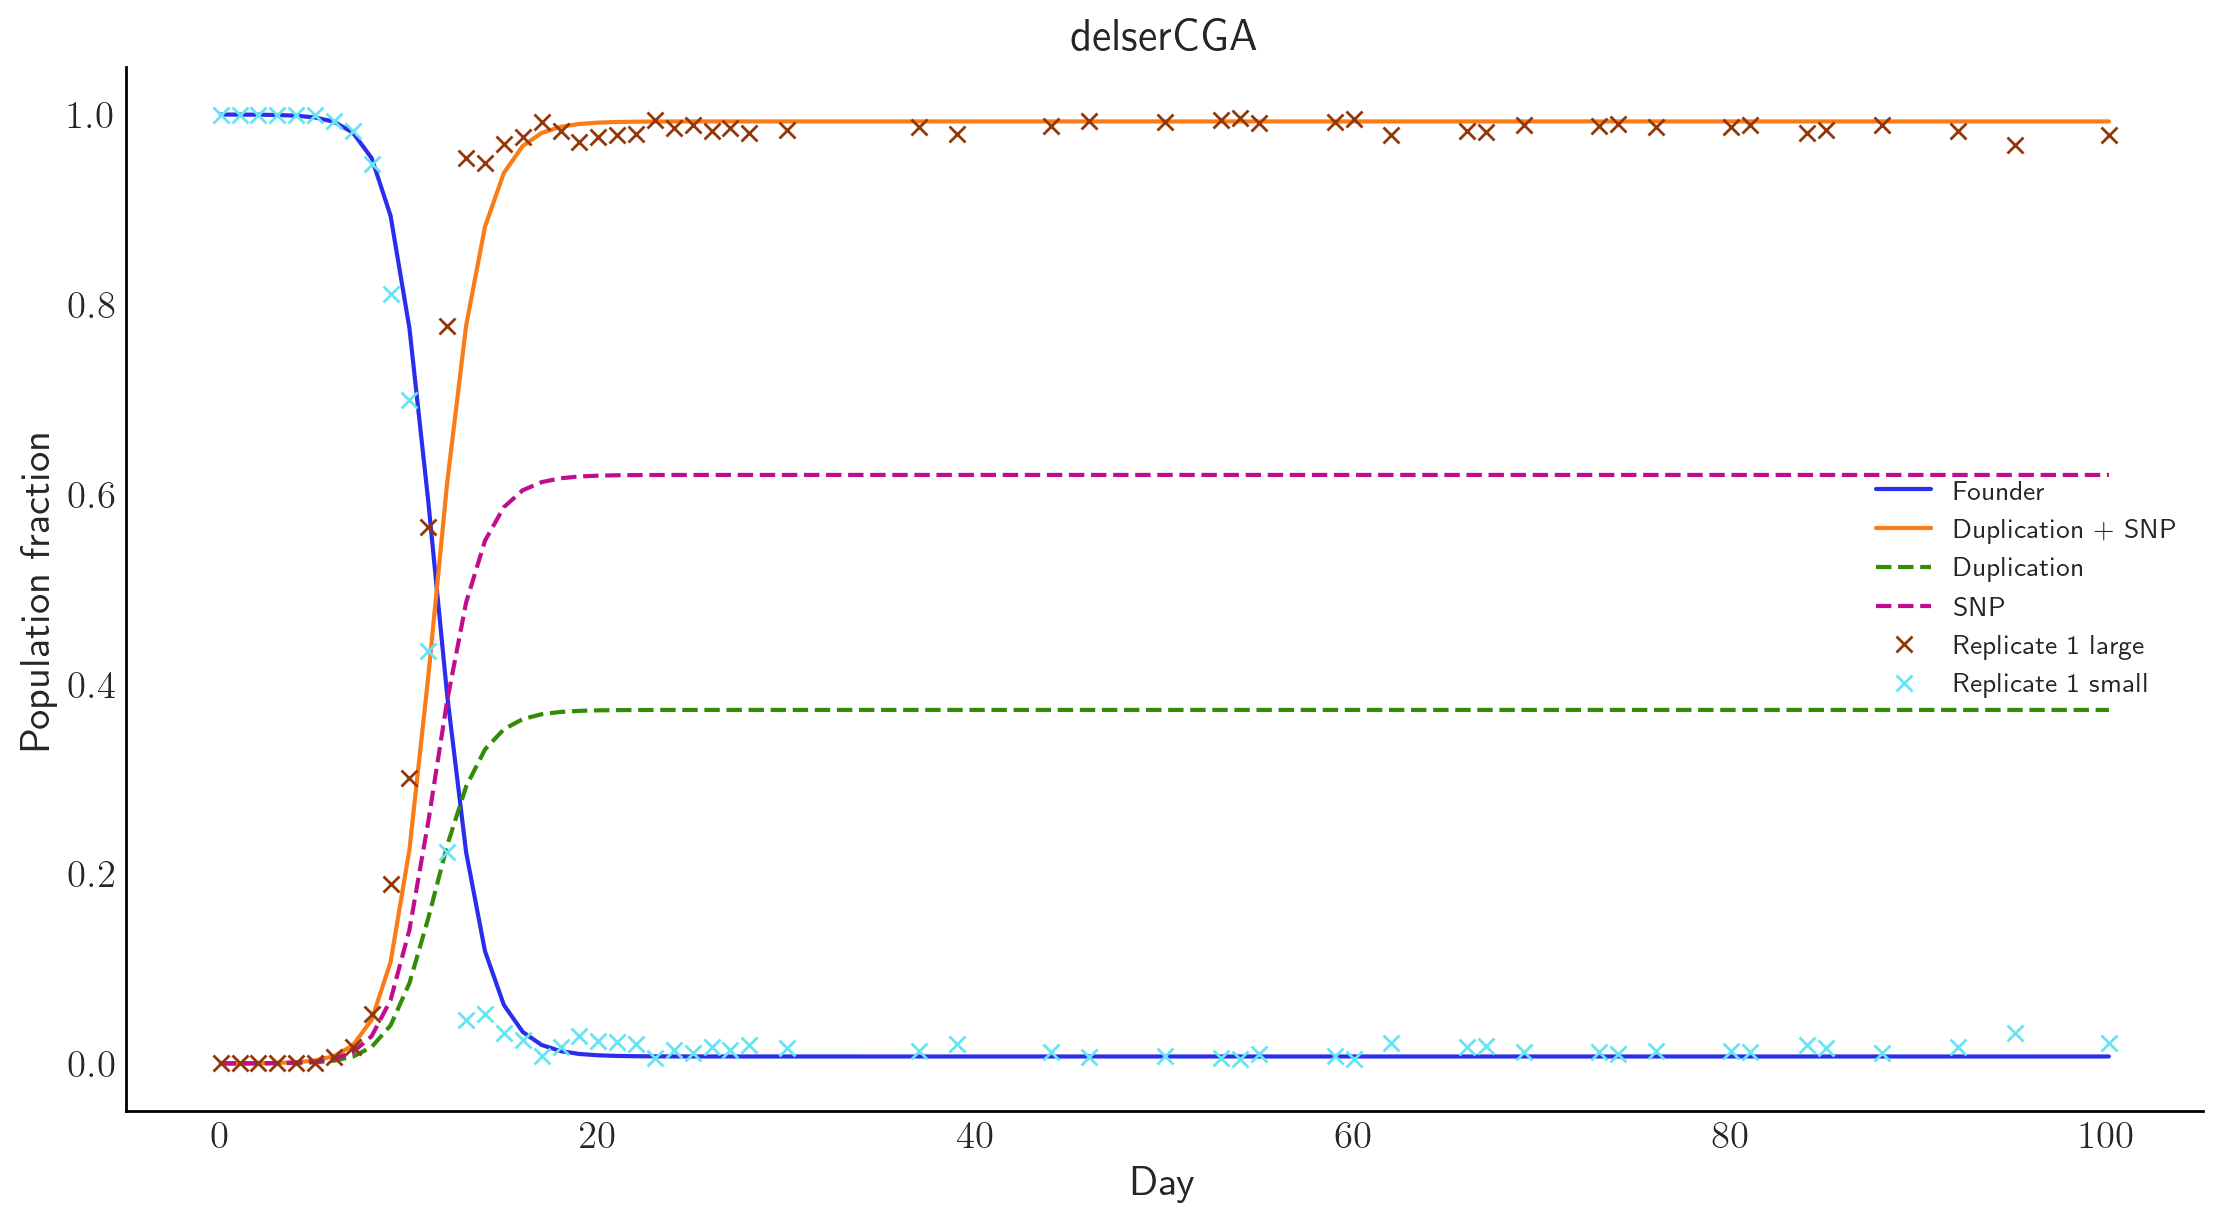

In [347]:
az.style.use("arviz-white")
ax = updated_model_3.plot_evolution_frac()
ax.plot(temp_df.day.values , temp_df.frac_large, 'x', label = f'Replicate 1 large')
ax.plot(temp_df.day.values , temp_df.frac_small, 'x', label = f'Replicate 1 small')
ax.legend(loc = "right", fontsize = 10)
fig = plt.gcf();
fig.savefig(CWD + '/plots/abc_3st_experiment_comparison.png', dpi = 300);
#plt.show();
